# TAMARA Agentic Graph - LangGraph Implementation

This notebook demonstrates the implementation of a TAMARA agentic graph using LangGraph, following the specifications in `TamaraAgent_spec.md`. The graph includes:

1. **Routing Logic**: Classifies user intent (knowledge queries vs operations)
2. **Input Collection**: Gathers and validates operation parameters
3. **Safety Precautions**: Implements safety checks and confirmations
4. **Action Execution**: Executes operations with proper validation
5. **RAG Integration**: Provides knowledge-based responses

The implementation uses dummy functions for tools to focus on graph structure and visualization.

In [41]:
# Core imports following TamaraAgent_spec.md
from typing import TypedDict, Annotated, Sequence, List, Union, Optional, Literal, Dict, Any
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
import os
import time

# Load environment variables
load_dotenv()

True

In [42]:
# AgentState following TamaraAgent_spec.md patterns
class AgentState(TypedDict, total=False):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    intent: Optional[Literal["ask_kb", "run", "clean", "ptest", "other"]]
    pending_action: Optional[str]  # "run"|"clean"|"ptest" when waiting for confirmation
    input_payload: Optional[Dict[str, Any]]  # Operation parameters
    confirmed: bool
    last_mode_check: float  # timestamp of last operation mode check

In [43]:
# Dummy tools implementation (simplified versions of tamara_graph.py tools)

@tool
def dummy_plc_interface() -> str:
    """Dummy PLC interface for testing - simulates PLC communication"""
    return "PLC connection established (dummy)"

@tool
def dummy_rag_query(query: str) -> str:
    """Dummy RAG query tool - simulates knowledge base retrieval"""
    return f"RAG response for query: '{query}' - This is a dummy response from the knowledge base."

@tool
def dummy_parameter_validation(params: Dict[str, Any]) -> str:
    """Dummy parameter validation tool"""
    return f"Parameters validated successfully: {params}"

@tool
def dummy_operation_execution(operation: str, params: Dict[str, Any]) -> str:
    """Dummy operation execution tool"""
    return f"Executing {operation} operation with parameters: {params}"

# Router function - classifies user intent
def route(state: AgentState) -> AgentState:
    """Route user messages to appropriate handlers based on intent."""
    last_message = state["messages"][-1]
    if isinstance(last_message, HumanMessage):
        user_text = last_message.content.lower()
    else:
        user_text = str(last_message).lower()
    
    # Simple heuristic routing
    if any(k in user_text for k in ["run", "formulate", "mix"]):
        state["intent"] = "run"
    elif "clean" in user_text:
        state["intent"] = "clean"
    elif "pressure" in user_text and "test" in user_text:
        state["intent"] = "ptest"
    elif any(k in user_text for k in ["status", "stop", "pause", "play"]):
        state["intent"] = "other"
    else:
        state["intent"] = "ask_kb"  # default to knowledge query
    
    return state



In [44]:
# Node implementations for the TAMARA agentic graph

def answer_with_rag(state: AgentState) -> AgentState:
    """Handle knowledge base queries using RAG"""
    last_message = state["messages"][-1]
    if isinstance(last_message, HumanMessage):
        query = last_message.content
    else:
        query = str(last_message)
    
    # Use dummy RAG tool
    rag_response = dummy_rag_query(query)
    state["messages"].append(AIMessage(content=rag_response))
    return state

def collect_run_inputs(state: AgentState) -> AgentState:
    """Collect and validate run operation parameters"""
    # Dummy parameter collection
    dummy_params = {
        "tfr": 2.0,
        "frr": 5,
        "target_volume": 10.0,
        "temperature": 25.0,
        "chip_id": "BAFFLE",
        "manifold": "SMALL",
        "solvent_type": "ethanol"
    }
    
    # Validate parameters
    validation_result = dummy_parameter_validation(dummy_params)
    state["messages"].append(AIMessage(content=f"Run parameters collected: {validation_result}"))
    state["input_payload"] = dummy_params
    state["pending_action"] = "run"
    return state

def collect_clean_inputs(state: AgentState) -> AgentState:
    """Collect and validate clean operation parameters"""
    dummy_params = {
        "tfr": 1.5,
        "frr": 3,
        "target_volume": 5.0,
        "temperature": 30.0,
        "chip_id": "HERRINGBONE",
        "manifold": "LARGE",
        "solvent_type": "ipa"
    }
    
    validation_result = dummy_parameter_validation(dummy_params)
    state["messages"].append(AIMessage(content=f"Clean parameters collected: {validation_result}"))
    state["input_payload"] = dummy_params
    state["pending_action"] = "clean"
    return state

def collect_ptest_inputs(state: AgentState) -> AgentState:
    """Collect and validate pressure test parameters"""
    dummy_params = {
        "tfr": 1.0,
        "frr": 1,
        "target_volume": 2.0,
        "temperature": 20.0,
        "chip_id": "BAFFLE",
        "manifold": "SMALL",
        "solvent_type": "water"
    }
    
    validation_result = dummy_parameter_validation(dummy_params)
    state["messages"].append(AIMessage(content=f"Pressure test parameters collected: {validation_result}"))
    state["input_payload"] = dummy_params
    state["pending_action"] = "ptest"
    return state

def show_precautions_run(state: AgentState) -> AgentState:
    """Show safety precautions for run operation"""
    precautions = (
        "Before we proceed with RUN operation, please confirm:\n"
        "1) Required fluids are loaded in the reservoirs per protocol.\n"
        "2) Chip is correctly seated & oriented; gasket in place; manifold connected.\n"
        "3) Lid is CLOSED; lines secure; drain bottle in place.\n"
        "4) Pressure supply within specifications.\n"
        "Type 'confirm' to continue or 'cancel' to abort."
    )
    state["messages"].append(AIMessage(content=precautions))
    return state

def show_precautions_clean(state: AgentState) -> AgentState:
    """Show safety precautions for clean operation"""
    precautions = (
        "Before we proceed with CLEAN operation, please confirm:\n"
        "1) Cleaning solution is loaded in reservoirs.\n"
        "2) Chip is correctly seated & oriented; gasket in place; manifold connected.\n"
        "3) Lid is CLOSED; lines secure; drain bottle has sufficient capacity.\n"
        "4) Pressure supply within specifications.\n"
        "WARNING: Once started, the cleaning cycle must complete for safety.\n"
        "Type 'confirm' to continue or 'cancel' to abort."
    )
    state["messages"].append(AIMessage(content=precautions))
    return state

def show_precautions_ptest(state: AgentState) -> AgentState:
    """Show safety precautions for pressure test operation"""
    precautions = (
        "Before we proceed with PRESSURE TEST operation, please confirm:\n"
        "1) System is properly prepared for pressure testing.\n"
        "2) Chip is correctly seated & oriented; gasket in place; manifold connected.\n"
        "3) Lid is CLOSED and secured; lines are secure and rated for test pressure.\n"
        "4) Area is clear of personnel; emergency stop is accessible.\n"
        "WARNING: Stand clear during pressure test.\n"
        "Type 'confirm' to continue or 'cancel' to abort."
    )
    state["messages"].append(AIMessage(content=precautions))
    return state

def execute_run(state: AgentState) -> AgentState:
    """Execute run operation"""
    if state.get("input_payload"):
        result = dummy_operation_execution("run", state["input_payload"])
        state["messages"].append(AIMessage(content=f"RUN operation completed: {result}"))
    else:
        state["messages"].append(AIMessage(content="Error: No parameters available for run operation"))
    return state

def execute_clean(state: AgentState) -> AgentState:
    """Execute clean operation"""
    if state.get("input_payload"):
        result = dummy_operation_execution("clean", state["input_payload"])
        state["messages"].append(AIMessage(content=f"CLEAN operation completed: {result}"))
    else:
        state["messages"].append(AIMessage(content="Error: No parameters available for clean operation"))
    return state

def execute_ptest(state: AgentState) -> AgentState:
    """Execute pressure test operation"""
    if state.get("input_payload"):
        result = dummy_operation_execution("pressure_test", state["input_payload"])
        state["messages"].append(AIMessage(content=f"PRESSURE TEST operation completed: {result}"))
    else:
        state["messages"].append(AIMessage(content="Error: No parameters available for pressure test operation"))
    return state

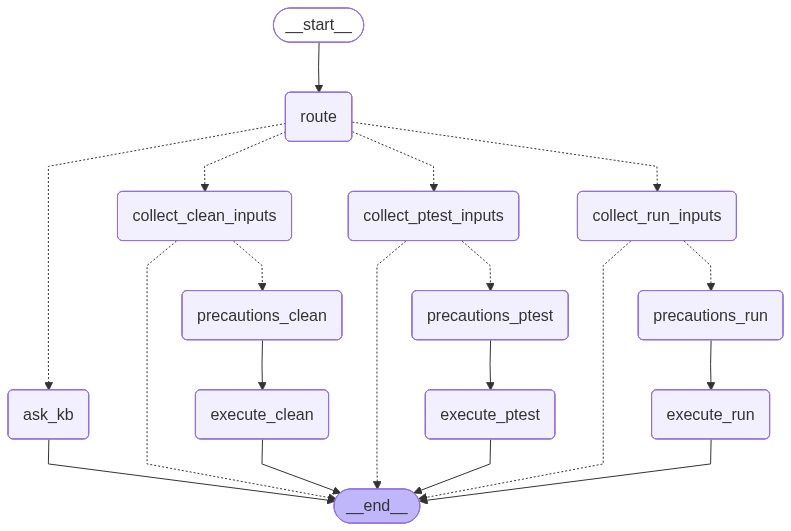

Graph visualization generated successfully!


In [45]:
# Build the TAMARA agentic graph
def build_tamara_graph():
    """Build the TAMARA agentic graph with proper routing and flow control"""
    graph = StateGraph(AgentState)
    
    # Add all nodes
    graph.add_node("route", route)
    graph.add_node("ask_kb", answer_with_rag)
    graph.add_node("collect_run_inputs", collect_run_inputs)
    graph.add_node("collect_clean_inputs", collect_clean_inputs)
    graph.add_node("collect_ptest_inputs", collect_ptest_inputs)
    graph.add_node("precautions_run", show_precautions_run)
    graph.add_node("precautions_clean", show_precautions_clean)
    graph.add_node("precautions_ptest", show_precautions_ptest)
    graph.add_node("execute_run", execute_run)
    graph.add_node("execute_clean", execute_clean)
    graph.add_node("execute_ptest", execute_ptest)
    
    # Set entry point
    graph.set_entry_point("route")
    
    # Routing logic based on intent
    def route_intent(state: AgentState) -> str:
        """Route based on user intent"""
        intent = state.get("intent", "ask_kb")
        
        if intent == "ask_kb":
            return "ask_kb"
        elif intent == "run":
            return "collect_run_inputs"
        elif intent == "clean":
            return "collect_clean_inputs"
        elif intent == "ptest":
            return "collect_ptest_inputs"
        else:
            return "ask_kb"  # default to knowledge query
    
    # Handle input collection routing
    def route_after_input_collection(state: AgentState, action: str) -> str:
        """Route after input collection to precautions"""
        if state.get("input_payload") and state.get("pending_action"):
            return f"precautions_{action}"
        return END
    
    # Add conditional edges
    graph.add_conditional_edges(
        "route",
        route_intent,
        {
            "ask_kb": "ask_kb",
            "collect_run_inputs": "collect_run_inputs",
            "collect_clean_inputs": "collect_clean_inputs",
            "collect_ptest_inputs": "collect_ptest_inputs"
        }
    )
    
    # Add edges from input collection to precautions
    for action in ["run", "clean", "ptest"]:
        graph.add_conditional_edges(
            f"collect_{action}_inputs",
            lambda s, a=action: route_after_input_collection(s, a),
            {
                f"precautions_{action}": f"precautions_{action}",
                END: END
            }
        )
    
    # Add edges from precautions to execution
    graph.add_edge("precautions_run", "execute_run")
    graph.add_edge("precautions_clean", "execute_clean")
    graph.add_edge("precautions_ptest", "execute_ptest")
    
    # Add terminal edges
    graph.add_edge("ask_kb", END)
    graph.add_edge("execute_run", END)
    graph.add_edge("execute_clean", END)
    graph.add_edge("execute_ptest", END)
    
    return graph.compile()

# Build and compile the graph
app = build_tamara_graph()

# Visualize the graph
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
    print("Graph visualization generated successfully!")
except Exception as e:
    print(f"Could not generate graph visualization: {e}")
    print("Graph structure:")
    print(app.get_graph().print_ascii())

In [51]:
# Test the TAMARA agentic graph with different scenarios

def test_graph_with_message(message: str):
    """Test the graph with a specific user message"""
    print(f"\n=== Testing with message: '{message}' ===")
    
    # Initialize state
    initial_state = {
        "messages": [HumanMessage(content=message)],
        "intent": None,
        "pending_action": None,
        "input_payload": None,
        "confirmed": False,
        "last_mode_check": time.time()
    }
    
    # Run the graph
    result = app.invoke(initial_state)
    
    # Display results
    print("Final state:")
    for key, value in result.items():
        if key != "messages":
            print(f"  {key}: {value}")
    
    print("\nMessages:")
    for i, msg in enumerate(result["messages"]):
        if isinstance(msg, HumanMessage):
            print(f"  {i}: Human: {msg.content}")
        elif isinstance(msg, AIMessage):
            print(f"  {i}: AI: {msg.content}")
    
    return result

# Test different scenarios
print("Testing TAMARA Agentic Graph")
print("=" * 50)

# Test 1: Knowledge query
test_graph_with_message("What is TAMARA?")

# Test 2: Run operation
# test_graph_with_message("I want to run a formulation")

# Test 3: Clean operation  
# test_graph_with_message("Start cleaning cycle")

# Test 4: Pressure test
# test_graph_with_message("Perform pressure test")

Testing TAMARA Agentic Graph

=== Testing with message: 'What is TAMARA?' ===
Final state:
  intent: ask_kb
  pending_action: None
  input_payload: None
  confirmed: False
  last_mode_check: 1757671250.3269656

Messages:
  0: Human: What is TAMARA?
  1: AI: RAG response for query: 'What is TAMARA?' - This is a dummy response from the knowledge base.


{'messages': [HumanMessage(content='What is TAMARA?', additional_kwargs={}, response_metadata={}, id='24e9e431-f4c2-40dc-b06b-6730d1be4223'),
  AIMessage(content="RAG response for query: 'What is TAMARA?' - This is a dummy response from the knowledge base.", additional_kwargs={}, response_metadata={}, id='a8f61734-22b2-4eab-ae3a-d1fac0570ad5')],
 'intent': 'ask_kb',
 'pending_action': None,
 'input_payload': None,
 'confirmed': False,
 'last_mode_check': 1757671250.3269656}

In [47]:
# Interactive testing function
# def interactive_test():
#     """Interactive testing of the TAMARA agentic graph"""
#     print("\n" + "="*60)
#     print("INTERACTIVE TAMARA AGENTIC GRAPH TESTING")
#     print("="*60)
#     print("Try different commands:")
#     print("- Knowledge queries: 'What is TAMARA?', 'How does microfluidics work?'")
#     print("- Operations: 'run', 'clean', 'pressure test'")
#     print("- Type 'exit' to quit")
#     print("-"*60)
    
#     while True:
#         try:
#             user_input = input("\nEnter your message: ").strip()
#             if not user_input:
#                 continue
#             if user_input.lower() in ['exit', 'quit']:
#                 print("Exiting interactive test...")
#                 break
            
#             # Test the graph
#             test_graph_with_message(user_input)
            
#         except KeyboardInterrupt:
#             print("\nExiting interactive test...")
#             break
#         except Exception as e:
#             print(f"Error: {e}")

# # Uncomment the line below to run interactive testing
# # interactive_test()

# # Alternative: Test with a single message
# print("\n" + "="*60)
# print("SINGLE MESSAGE TEST")
# print("="*60)
# test_graph_with_message("Tell me about TAMARA specifications")